In [1]:
import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K 
"""
keras.backend即后端，其实就是将深度学习向比layer更小的方法即函数下沉，更能实现灵活性；这里的方法即函数层，其实就是一些基本的数值处理方法，
例如求均值的mean、求最大值的max，求点积的dot等，这些方法组合就可以形成一个layer,loss等基本的层
"""
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, concatenate, Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
imgs_train = np.load("C:/Users/XuChen/unet10.13/npydata/imgs_train.npy") # 加载训练原图
imgs_mask_train = np.load("C:/Users/XuChen/unet10.13/npydata/imgs_mask_train.npy") # 加载训练标记图
imgs_test = np.load("C:/Users/XuChen/unet10.13/npydata/imgs_test.npy")

In [3]:
# model 

inputs = Input((512,512,1),name='input')

conv1 =  Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv1')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv2')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv3')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv4')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv5')(pool4)

up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='up6')(UpSampling2D(size = (2,2))(conv5))
merge6 = concatenate([conv4,up6],axis=3)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv6')(merge6)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='up7')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7],axis=3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv7')(merge7)

up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='up8')(UpSampling2D(size = (2,2))(conv7))
merge8= concatenate([conv2,up8],axis=3)
conv8 = Conv2D(16,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv8')(merge8)

up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='up9')(UpSampling2D(size = (2,2), name='up10')(conv8))
merge9= concatenate([conv1,up9],axis=3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='conv9')(merge9)
conv10 = Conv2D(1, 1, activation = 'sigmoid', name='conv10')(conv9)

model = Model(inputs = inputs, outputs = conv10)

In [4]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
"""
用于在配置训练方法时，告知训练时用的优化器、损失函数和准确率评测标准
optimizer = 优化器，如："sgd"  或者  tf.optimizers.SGD(lr = 学习率，decay = 学习率衰减率，momentum = 动量参数）
                     "adagrad" 或者  tf.keras.optimizers.Adagrad(lr = 学习率，decay = 学习率衰减率）
                    "adadelta" 或者  tf.keras.optimizers.Adadelta(lr = 学习率，decay = 学习率衰减率）
                        "adam" 或者  tf.keras.optimizers.Adam(lr = 学习率，decay = 学习率衰减率）
loss = 损失函数，loss可以是字符串形式给出的损失函数的名字，也可以是函数形式
                        如：”mse" 或者 tf.keras.losses.MeanSquaredError()
"sparse_categorical_crossentropy"  或者  tf.keras.losses.SparseCatagoricalCrossentropy(from_logits = False)
损失函数经常需要使用softmax函数来将输出转化为概率分布的形式，在这里from_logits代表是否将输出转为概率分布的形式，为False时表示转换为概率分布，为True时表示不转换，直接输出

metrics = ["准确率”] 标注网络评价指标,例如：
                        "accuracy" : y_ 和 y 都是数值，如y_ = [1] y = [1]  #y_为真实值，y为预测值
                 "sparse_accuracy" : y_和y都是以独热(one-hot)码和概率分布表示，如y_ = [0, 1, 0], y = [0.256, 0.695, 0.048]
     "sparse_categorical_accuracy" : y_是以数值形式给出，y是以独热码给出，如y_ = [1], y = [0.256 0.695, 0.048]
"""

model.summary() # 输出模型各层的参数状况

D:\python3.9.7\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 8)  80          input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 256, 256, 8)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 256, 256, 16) 1168        pool1[0][0]                      
______________________________________________________________________________________________

In [5]:
model_checkpoint = ModelCheckpoint(filepath='C:/Users/XuChen/Desktop/1125.hdf5',monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None)
'''
ModelCheckpoint 回调与使用 model.fit() 的训练结合使用以在某个时间间隔保存模型或权重（在检查点文件中），
                因此可以稍后加载模型或权重以从保存的状态继续训练。
filepath 文件保存路径
monitor:监视器
verbose:verbosity mode详细模式 0或者1
save_best_only：
'''
model.fit(x=imgs_train, y=imgs_mask_train, batch_size=1, epochs=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

"""
x：输入数据。如果模型只有一个输入，那么x的类型是numpy array，如果模型有多个输入，那么x的类型应当为list，
   list的元素是对应于各个输入的numpy array
y：标签，numpy array
batch_size：整数，指定进行梯度下降时每个batch包含的样本数。
            训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。
epochs：整数，训练终止时的epoch值，训练将在达到该epoch值时停止，当没有设置initial_epoch时，它就是训练的总轮数，
        否则训练的总轮数为epochs - inital_epoch
verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
callbacks：list，其中的元素是keras.callbacks.Callback的对象。这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数
validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，
                  如损失函数、精确度等。注意，validation_split的划分在shuffle之前，因此如果你的数据本身是有序的，
                  需要先手工打乱再指定validation_split，否则可能会出现验证集样本不均匀。
validation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
shuffle：布尔值或字符串，一般为布尔值，表示是否在训练过程中随机打乱输入样本的顺序。若为字符串“batch”，则是用来处理HDF5数据的特殊情况，
         它将在batch内部将数据打乱。
class_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）

sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。
                可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，
                传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权。
                这种情况下请确定在编译模型时添加了sample_weight_mode=’temporal’。

initial_epoch: 从该参数指定的epoch开始训练，在继续之前的训练时有用。
fit函数返回一个History的对象，其History.history属性记录了损失函数和其他指标的数值随epoch变化的情况，如果有验证集的话，也包含了验证集的这些指标变化情况
"""

Epoch 1/10
24/24 [==============================] - 95s 1s/step - loss: -22407.6621 - accuracy: 5.1181e-05 - val_loss: -44177.2812 - val_accuracy: 3.8147e-06
Epoch 2/10
24/24 [==============================] - 26s 1s/step - loss: -227183.7969 - accuracy: 9.5367e-07 - val_loss: -965047.5000 - val_accuracy: 0.0000e+00
Epoch 3/10
24/24 [==============================] - 26s 1s/step - loss: -6971634.5000 - accuracy: 0.0000e+00 - val_loss: -31544680.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
24/24 [==============================] - 26s 1s/step - loss: -238095232.0000 - accuracy: 0.0000e+00 - val_loss: -1023691520.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
24/24 [==============================] - 25s 1s/step - loss: -5906311680.0000 - accuracy: 0.0000e+00 - val_loss: -22606772224.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
24/24 [==============================] - 29s 1s/step - loss: -102854336512.0000 - accuracy: 0.0000e+00 - val_loss: -374721642496.0000 - val_accuracy: 0.0000e+00
Epoch 7/10


'\nx：输入数据。如果模型只有一个输入，那么x的类型是numpy array，如果模型有多个输入，那么x的类型应当为list，\n   list的元素是对应于各个输入的numpy array\ny：标签，numpy array\nbatch_size：整数，指定进行梯度下降时每个batch包含的样本数。\n            训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。\nepochs：整数，训练终止时的epoch值，训练将在达到该epoch值时停止，当没有设置initial_epoch时，它就是训练的总轮数，\n        否则训练的总轮数为epochs - inital_epoch\nverbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录\ncallbacks：list，其中的元素是keras.callbacks.Callback的对象。这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数\nvalidation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，\n                  如损失函数、精确度等。注意，validation_split的划分在shuffle之前，因此如果你的数据本身是有序的，\n                  需要先手工打乱再指定validation_split，否则可能会出现验证集样本不均匀。\nvalidation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。\nshuffle：布尔值或字符串，一般为布尔值，表示是否在训练过程中随机打乱输入样本的顺序。若为字符串“batch”，则是用来处理HDF5数据的特殊情况，\n         它将在batch内部将数据打乱。\nclass_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）\n\nsample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。\n                可以传递一个1D的与样本等长的向量用于对样本进行1

In [6]:
imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
"""
model.predict(X_test, batch_size=32，verbose=1)
X_test：为即将要预测的测试集
batch_size:为一次性输入多少张图片给网络进行训练，最后输入图片的总数为测试集的个数
verbose:1代表显示进度条，0不显示进度条，默认为0
返回值：每个测试集的所预测的各个类别的概率
"""

30/30 [==============================] - 19s 421ms/step


'\nmodel.predict(X_test, batch_size=32，verbose=1)\nX_test：为即将要预测的测试集\nbatch_size:为一次性输入多少张图片给网络进行训练，最后输入图片的总数为测试集的个数\nverbose:1代表显示进度条，0不显示进度条，默认为0\n返回值：每个测试集的所预测的各个类别的概率\n'

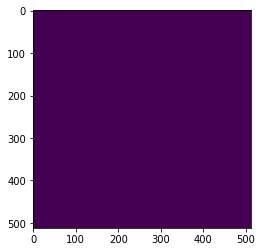

In [7]:
import matplotlib.pyplot as plt

plt.imshow(imgs_mask_test[1])

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, concatenate, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam








class UNetPlusPlus():
    
    """ 
    Unet++ Model design.
    
    This module consumes the Unet utilities framework moule and designs the Unet network.
    It consists of a contracting path and an expansive path. Both these paths are joined 
    by a bottleneck block.
    
    The different blocks involved in the design of the network can be referenced @ 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    
    Reference:
        [1] UNet++: A Nested U-Net Architecture for Medical Image Segmentation.
            https://arxiv.org/abs/1807.10165
            
        [2] https://paperswithcode.com/paper/unet-a-nested-u-net-architecture-for-medical
    """
    
    def __init__(self, input_shape = (128, 128, 1), filters = [16, 32, 64, 128, 256], nb_classes = 1, deep_supervision = False):
        
        """
        Initialize the Unet framework and the model parameters - input_shape, 
        filters and padding type. 
        
        Args:
            input_shape (tuple): A shape tuple (integers), not including the batch size.
                                 Default value is (512, 512, 1).
                                 
            filters (array of integers: a collection of filters denoting the number of components to be used at each blocks along the 
                        contracting and expansive paths. The original paper implementation for number of filters along the 
                        contracting and expansive paths are [32, 64, 128, 256, 512]. (as per paper: k = 32 × 2^i).
                        
            nb_classes (Integer): the dimensionality (no. of filters) of the output space .
                        (i.e. the number of output filters in the convolution).
            deep_supervision (boolean): A flag that toggles between the 2 different training modes -
                                        1) the ACCURATE mode - where the outputs from all segmentation 
                                           branches are averaged., 
                                        2) the FAST mode - wherein the final segmentation map is selected from 
                                           only one of the segmentation branches.
                                        Default vaue - False
            
        **Remarks: The default values are as per the implementation in the original paper @ https://arxiv.org/pdf/1505.04597
         
        """

        self.__input_shape = input_shape
        self.__filters = filters
        self.__nb_classes = nb_classes
        self.__deep_supervision = deep_supervision
        self.__smooth = 1. # Used to prevent the denominator from 0 when computing the DICE coefficient.？
    
    def BuildNetwork(self):

        """
        Creates the UNet++ Netwrork for biomedical image segmentation.
        Args:
            None
            
        Returns:
            model: the neural network model representing the UNet++ model architechture.
        """

        input_img = Input(shape = self.__input_shape, name = 'InputLayer')

        conv00 = self.__InsertConvolutionBlock(input_img, block_level = '00', filters = self.__filters[0])
        pool0 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool0')(conv00)

        conv10 = self.__InsertConvolutionBlock(pool0, block_level = '10', filters = self.__filters[1])
        pool1 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool1')(conv10)

        up01 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding='same', name='upsample01')(conv10)
        conv01 = concatenate([up01, conv00], name='concat01')
        conv01 = self.__InsertConvolutionBlock(conv01, block_level = '01', filters = self.__filters[0])

        conv20 = self.__InsertConvolutionBlock(pool1, block_level = '20', filters = self.__filters[2])
        pool2 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool2')(conv20)

        up11 = Conv2DTranspose(filters = self.__filters[1], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample11')(conv20)
        conv11 = concatenate([up11, conv10], name = 'concat11')
        conv11 = self.__InsertSkipPathway(conv11, block_level = '11', filters = self.__filters[1])

        up02 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding='same', name='upsample02')(conv11)
        conv02 = concatenate([up02, conv00, conv01], name = 'concat02')
        conv02 = self.__InsertConvolutionBlock(conv02, block_level = '02', filters = self.__filters[0])

        conv30 = self.__InsertConvolutionBlock(pool2, block_level = '30', filters = self.__filters[3])
        pool3 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool3')(conv30)

        up21 = Conv2DTranspose(filters = self.__filters[2], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample21')(conv30)
        conv21 = concatenate([up21, conv20], name='concat21')

        conv21 = self.__InsertConvolutionBlock(conv21, block_level='21', filters = self.__filters[2])

        up12 = Conv2DTranspose(filters = self.__filters[1], kernel_size = 2, strides = 2, padding='same', name = 'upsample12')(conv21)
        conv12 = concatenate([up12, conv10, conv11], name = 'concat12')
        conv12 = self.__InsertSkipPathway(conv12, block_level = '12', filters = self.__filters[1])

        up03 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample03')(conv12)
        conv03 = concatenate([up03, conv00, conv01, conv02], name = 'concat03')
        conv03 = self.__InsertConvolutionBlock(conv03, block_level = '03', filters = self.__filters[0])

        conv40 = self.__InsertConvolutionBlock(pool3, block_level = '40', filters = self.__filters[4])

        up31 = Conv2DTranspose(filters = self.__filters[3], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample31')(conv40)
        conv31 = concatenate([up31, conv30], name = 'concat31')
        conv31 = self.__InsertSkipPathway(conv31, block_level = '31', filters=self.__filters[3])

        up22 = Conv2DTranspose(filters = self.__filters[2], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample22')(conv31)
        conv22 = concatenate([up22, conv20, conv21], name = 'concat22')
        conv22 = self.__InsertSkipPathway(conv22, block_level = '22', filters = self.__filters[2])

        up13 = Conv2DTranspose(filters = self.__filters[1], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample13')(conv22)
        conv13 = concatenate([up13, conv10, conv11, conv12], name='concat13')
        conv13 = self.__InsertSkipPathway(conv13, block_level = '13', filters = self.__filters[1])

        up04 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample04')(conv13)
        conv04 = concatenate([up04, conv00, conv01, conv02, conv03], name = 'concat04')
        conv04 = self.__InsertConvolutionBlock(conv04, block_level = '04', filters = self.__filters[0])

        nested_op_1 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op1')(conv01)

        nested_op_2 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op2')(conv02)

        nested_op_3 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding= 'same', name = 'op3')(conv03)

        nested_op_4 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op4')(conv04)

        if self.__deep_supervision:
            output = [nested_op_1, nested_op_2, nested_op_3, nested_op_4]
        else:
            output = [nested_op_4]

        model = Model(inputs = input_img, outputs = output, name = "UNetPP")
        
        return model

    def __InsertSkipPathway(self, input_tensor, block_level, filters, kernel_size = 3):

        """
        Inserts a convolution block along the skip pathways.
        Args:
            input_tensor: The input that would go into the convolutional block.
            block_level: the level of the current block.
            filters: the dimensionality (no. of filters) of the output space 
                        (i.e. the number of output filters in the convolution).
            kernel_size: the size of the convolving window. Default value is 3.
                         All convolutional layers along a skip pathway (X(i, j) )
                         use k kernels of size 3×3.
        Returns:
            x: The 2D convolution output.
        """
        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_1')(input_tensor)

        x = Dropout(rate = 0.5, name = 'X' + block_level + '_')(x)

        #x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
        #           padding = 'same', name = 'conv' + block_level + '_2')(x)

        #x = Dropout(rate = 0.5, name = 'X' + block_level)(x)

        return x

    def __InsertConvolutionBlock(self, input_tensor, block_level, filters, kernel_size = 3):

        """
        Inserts a convolution block along the contracting 
        and expanding paths of the network.
        Args:
            input_tensor: The input that would go into the convolutional block.
            block_level: the level of the current block.
            filters: the dimensionality (no. of filters) of the output space 
                        (i.e. the number of output filters in the convolution).
            kernel_size: the size of the convolving window. Default value is 3.            
        Returns:
            x: The 2D convolution output.
        """

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_1')(input_tensor)

        x = Dropout(rate = 0.5, name = 'X' + block_level + '_')(x)

        #x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
        #           padding = 'same', name = 'conv' + block_level + '_2')(x)

        #x = Dropout(rate = 0.5, name = 'X' + block_level)(x)

        return x
    
    # WARNING:tensorflow:AutoGraph could not transform <bound method UNetPlusPlus.__dice_coef_loss of 
    # <UNetPP.UNetPlusPlus object at 0x000001A33B0D8198>> and will run it as-is.
    # Cause: mangled names are not yet supported. To silence this warning, decorate the function with 
    # @tf.autograph.experimental.do_not_convert
    @tf.autograph.experimental.do_not_convert
    def __dice_coef(self, y_true, y_pred):
        
        """
        computes the dice loss. loss function for image segmentation 
        tasks is based on the Dice coefficient, which is essentially 
        a measure of overlap between two samples. This measure ranges 
        from 0 to 1 where a Dice coefficient of 1 denotes perfect and 
        complete overlap.
        
        Args:
            y_true: the true value of the image mask.
            y_pred: the predicted value of the image mask.
        
        Returns:
            dice_val: the dice loss value
            
        Ref:
            https://www.programmersought.com/article/11533881518/
            
        """
        
        y_true_f = K.flatten(y_true) # Extend y_true to one dimension.
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.__smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + self.__smooth)
    
    @tf.autograph.experimental.do_not_convert
    def __dice_coef_loss(self, y_true, y_pred):
        
        """
        computes the dice loss. loss function for image segmentation 
        tasks is based on the Dice coefficient, which is essentially 
        a measure of overlap between two samples. This measure ranges 
        from 0 to 1 where a Dice coefficient of 1 denotes perfect and 
        complete overlap.
        
        Args:
            y_true: the true value of the image mask.
            y_pred: the predicted value of the image mask.
        
        Returns:
            dice_val: the dice loss value
            
        Ref:
            https://www.programmersought.com/article/11533881518/
            
        """
        
        return 1. - self.__dice_coef(y_true, y_pred)
    
    
    @tf.autograph.experimental.do_not_convert
    def __iou_loss_core(self, y_true, y_pred):
        
        """
        computes the intersection over union metric. 
        Intersection over Union is an evaluation metric 
        used to measure the accuracy of an object/mask detected. 
        
        Args:
            y_true: the true value of the image mask.
            y_pred: the predicted value of the image mask.
            smooth: 
        
        Returns:
            iou: the iou coefficient.
            
        """
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
        iou = (intersection + self.__smooth) / ( union + self.__smooth)
        
        return iou
    
    def CompileAndSummarizeModel(self, model, optimizer = "adam", loss = "binary_crossentropy"):

        """
        Compiles and displays the model summary of the Unet++ model.
        Args:
            model: The keras instance of the Unet++ model.
            optimizer: model optimizer. Default is the adam optimizer.
            loss: the loss function. Default is the binary cross entropy loss.
        Return:
            None
        """
        model.compile(optimizer = optimizer, 
                      loss = self.__dice_coef_loss, 
                      metrics = ['acc', self.__iou_loss_core])
        
        model.summary()

    def plotModel(self, model, to_file = 'unetpp.png', show_shapes = True, dpi = 96):

        """
        Saves the Unet++ model plot/figure to a file.
        Args:
            model: The keras instance of the Unet++ model.
            to_file: the file name to save the model. Default name - 'unet.png'.
            show_shapes: whether to display shape information. Default = True.
            dpi: dots per inch. Default value is 96.
        Return:
            None
        """

        tf.keras.utils.plot_model(model, to_file = to_file, show_shapes = show_shapes, dpi = dpi)